 <h1  style="color:green">ANALISIS 60 SEGUNDOS</span>



Que es lo que se pide:

- Vamos a observar <span style="color:green">visitas</span> y <span style="color:green">agendas</span>

- HIPOTESIS: si lo atienden dentro de 60 segundos, es mas propenso a visitar.

- Pedirle a agustin los datos de las llamadas con los horarios y el tiempo de respuesta, mas el resultado de la llamada (si agenda y si visita).

- Comparar rangos de tiempo.

- "mande el primer mensaje, y espere x tiempo a que me atiendan"



- Probabilidad de visita, proporcional a las cantidades de gente que se atiende en menos de 60 segundos o mas.


- Hay datos repetidos, se necesita limpiar esos.

- Trabajo en un principio sin tomar en cuenta las respuestas automaticas de bots.


Se crea el contacto cuando pasa por la publicidad. comparo primera interaccion de salida con cuando se creo el contacto

# ingresosTot
<span style="color:lightgreen">lead_created se crea cada vez que se llena el form </span>

<span style="color:lightgreen">created se llena solo 1 vez, en el primer registro del cliente en la plataforma </span>

# interacciones salientes

<span style="color:lightgreen">fechaHora es cuando se envio el mensaje o el intento de llamada</span>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import functions as f

### LIMPIEZA

In [2]:
# Rutas de los archivos cargados nuevamente
path_interacciones_llamadas = '60segundosRevision/interaccionesLlamadas.csv'
path_ingresos_tot = '60segundosRevision/ingresosTot.csv'

# Leer los archivos CSV
ingresos_tot = pd.read_csv(path_ingresos_tot, low_memory=False)
interacciones_llamadas = pd.read_csv(path_interacciones_llamadas, low_memory=False)



ingresos_tot["created"] = pd.to_datetime(ingresos_tot["created"],format="mixed")
ingresos_tot = ingresos_tot[(ingresos_tot['lead_created'] >= '2025-02-01') & (ingresos_tot['lead_created'] < '2025-03-1')]

interacciones_llamadas["fechaHora"] = pd.to_datetime(interacciones_llamadas["fechaHora"],format="mixed")
interacciones_llamadas = interacciones_llamadas[(interacciones_llamadas['fechaHora'] >= '2025-02-01') & (interacciones_llamadas['fechaHora'] < '2025-03-1')]


#Filtro respuesta automatica
ingresos_tot = ingresos_tot[~ingresos_tot['agent_mail'].str.contains("supervisiondepto5@spazios.com.ar", case=False, na=False)]
interacciones_llamadas = interacciones_llamadas[~interacciones_llamadas['agente'].str.contains("supervisiondepto5@spazios.com.ar", case=False, na=False)]

# Asegurar los tipos correctos para merge
interacciones_llamadas['numCliente'] = interacciones_llamadas['numCliente'].astype(str)
ingresos_tot['last_phone'] = ingresos_tot['last_phone'].astype(str).str.replace(r'\.0$', '', regex=True)

interacciones_llamadas['numCliente'] = (
    interacciones_llamadas['numCliente']          # toma la columna
      .astype(str)          # se asegura de que sea texto
      .str.replace(r'^\+',  # solo “+” al principio
                   '', 
                   regex=True)
)
interacciones_llamadas['numCliente'] = interacciones_llamadas['numCliente'].str[-7:]

ingresos_tot['last_phone'] = (
    ingresos_tot['last_phone']          # toma la columna
      .astype(str)          # se asegura de que sea texto
      .str.replace(r'^\+',  # solo “+” al principio
                   '', 
                   regex=True)
)
ingresos_tot['last_phone'] = ingresos_tot['last_phone'].str[-7:]

# Realizar el merge con las columnas adicionales
resultante = pd.merge(
    interacciones_llamadas[['numCliente', 'fechaHora']],  
    ingresos_tot[['last_phone', 'lead_created', 'created', 'archivingReason']],  
    left_on='numCliente',  
    right_on='last_phone',
    how='inner' 
)

resultante.to_csv("resultante.csv", index=False)


In [3]:
# Filtrados los duplicados

#ingresos = resultante.loc[resultante['archivingReason'] != 'ingresoDuplicado' ]
ingresos = resultante.loc[resultante['archivingReason'] != 'inactive']
ingresos = ingresos.loc[ingresos['archivingReason'] != 'noContactable']

# Opcional: Guardar el resultado en un archivo CSV
ingresos.to_csv("resultante.csv", index=False)

# _Ahora lo cruzo con los ultimos 6 digitos de la columna telefono de meetings_


In [4]:
path_meetings = '60segundosRevision/meetings.csv'

meetings = pd.read_csv(path_meetings,low_memory=False)

meetings["Created Time"] = pd.to_datetime(meetings["Created Time"],format="mixed")

meetings = meetings[(meetings['Created Time'] >= '2025-02-01') & (meetings['Created Time'] < '2025-03-1')]

## hay mas de un telefono, en dos idiomas obviamente porque por que no
f.combine(meetings)




# Normalizo numeros

In [5]:
meetings['Telefono_final'] = (
    meetings['Telefono_final']          # toma la columna
      .astype(str)          # se asegura de que sea texto
      .str.replace(r'^\+',  # solo “+” al principio
                   '', 
                   regex=True)
)

<h4 style="color:lightgreen">Datasheet de usuarios que agendaron</span>

In [6]:
dfAgenda = pd.merge(
    ingresos[['numCliente', 'fechaHora', 'lead_created', 'created', 'archivingReason']],  
    meetings[['Estado Reunión','Telefono_final']], 
    left_on='numCliente',  
    right_on='Telefono_final',  
    how='inner'  
)

In [7]:
dfSinAgenda = pd.merge(
    ingresos[['numCliente', 'fechaHora', 'lead_created', 'created', 'archivingReason']],  
    meetings[['Telefono_final']],  
    left_on='numCliente', 
    right_on='Telefono_final', 
    how='left',
    indicator=True
)
print(dfSinAgenda)
# Filtrar las filas que están solo en 'ingresos_duplicados' (sin coincidencia)
dfSinAgenda = dfSinAgenda[dfSinAgenda['_merge'] == 'left_only']

# Eliminar la columna '_merge' (opcional)
dfSinAgenda = dfSinAgenda.drop(columns=['_merge'])


       numCliente           fechaHora         lead_created  \
0         3620581 2025-02-28 23:53:08  2025-02-28 23:52:59   
1         3620581 2025-02-28 23:52:59  2025-02-28 23:52:59   
2         5990092 2025-02-28 23:15:35  2025-02-03 02:19:26   
3         5990092 2025-02-28 23:15:35  2025-02-04 22:40:34   
4         5990092 2025-02-28 23:15:35  2025-02-05 09:34:07   
...           ...                 ...                  ...   
115827    7556566 2025-02-01 00:32:02  2025-02-01 00:32:50   
115828    7437127 2025-02-01 00:26:31  2025-02-01 00:25:48   
115829    7308530 2025-02-01 00:08:44  2025-02-01 00:07:18   
115830    7308530 2025-02-01 00:08:44  2025-02-01 00:08:41   
115831    8660154 2025-02-01 00:02:49  2025-02-01 00:02:46   

                   created      archivingReason Telefono_final     _merge  
0      2025-02-28 23:52:59  aLaEsperaDeZonaCaba            NaN  left_only  
1      2025-02-28 23:52:59  aLaEsperaDeZonaCaba            NaN  left_only  
2      2025-01-16 21:18:20 

In [8]:
dfAgenda["lead_created"] = pd.to_datetime(dfAgenda["lead_created"],format="mixed")


#dfAgenda["lead_created"] = dfAgenda["lead_created"].dt.tz_convert(None)

#dfAgenda["created"] = dfAgenda["created"].dt.tz_convert(None)

#dfAgenda["lead_created"] = dfAgenda["lead_created"] - pd.Timedelta(hours=3)

dfAgenda['tiempo_lead'] = dfAgenda['fechaHora'] - dfAgenda['lead_created']
dfAgenda['tiempo_creacion'] = dfAgenda['fechaHora'] - dfAgenda['created']

# Desglose del tiempo transcurrido en días, horas, minutos y segundos
dfAgenda['dias_lead'] = dfAgenda['tiempo_lead'].dt.days
dfAgenda['horas_lead'] = dfAgenda['tiempo_lead'].dt.components.hours
dfAgenda['minutos_lead'] = dfAgenda['tiempo_lead'].dt.components.minutes

dfAgenda['dias_creacion'] = dfAgenda['tiempo_creacion'].dt.days
dfAgenda['horas_creacion'] = dfAgenda['tiempo_creacion'].dt.components.hours
dfAgenda['minutos_creacion'] = dfAgenda['tiempo_creacion'].dt.components.minutes


In [9]:
### ahora para sin agenda
dfSinAgenda["fechaHora"] = pd.to_datetime(dfSinAgenda["fechaHora"],format="mixed")
dfSinAgenda["lead_created"] = pd.to_datetime(dfSinAgenda["lead_created"],format="mixed")
dfSinAgenda["created"] = pd.to_datetime(dfSinAgenda["created"],format="mixed")


#dfSinAgenda["lead_created"] = dfSinAgenda["lead_created"].dt.tz_convert(None)
#dfSinAgenda["created"] = dfSinAgenda["created"].dt.tz_convert(None)


#dfSinAgenda["lead_created"] = dfSinAgenda["lead_created"] - pd.Timedelta(hours=3)
#dfSinAgenda["created"] = dfSinAgenda["created"] - pd.Timedelta(hours=3)

dfSinAgenda['tiempo_lead'] = dfSinAgenda['fechaHora'] - dfSinAgenda['lead_created']
dfSinAgenda['tiempo_creacion'] = dfSinAgenda['fechaHora'] - dfSinAgenda['created']

# Desglose del tiempo transcurrido en días, horas, minutos y segundos
dfSinAgenda['dias_lead'] = dfSinAgenda['tiempo_lead'].dt.days
dfSinAgenda['horas_lead'] = dfSinAgenda['tiempo_lead'].dt.components.hours
dfSinAgenda['minutos_lead'] = dfSinAgenda['tiempo_lead'].dt.components.minutes

dfSinAgenda['dias_creacion'] = dfSinAgenda['tiempo_creacion'].dt.days
dfSinAgenda['horas_creacion'] = dfSinAgenda['tiempo_creacion'].dt.components.hours
dfSinAgenda['minutos_creacion'] = dfSinAgenda['tiempo_creacion'].dt.components.minutes


In [10]:
# Filtrar filas donde 'dias_leads' no sea negativo
dfAgenda = dfAgenda[dfAgenda['dias_lead'] >= 0]
dfAgenda = dfAgenda[dfAgenda['tiempo_lead'] > pd.Timedelta(seconds=30)]
# Verificar el resultado
print(dfAgenda['dias_lead'].min())  # Debería ser 0 o mayor


0


In [11]:
# Filtrar filas donde 'dias_leads' no sea negativo
dfSinAgenda = dfSinAgenda[dfSinAgenda['dias_lead'] >= 0]
dfSinAgenda = dfSinAgenda[dfSinAgenda['tiempo_lead'] > pd.Timedelta(seconds=30)]
# Verificar el resultado
print(dfSinAgenda['dias_lead'].min())  # Debería ser 0 o mayor

# Reemplazar valores vacíos o similares por NaN
dfSinAgenda = dfSinAgenda.replace(r'^\s*$', np.nan, regex=True)
dfSinAgenda = dfSinAgenda.dropna(how='all')


0


C:\Users\GiovanniMiceli\AppData\Local\Temp\ipykernel_7260\752506217.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfSinAgenda = dfSinAgenda.replace(r'^\s*$', np.nan, regex=True)


In [12]:
# Asegúrate de que la columna 'tiempo_lead' sea del tipo timedelta
#dfAgenda['tiempo_lead'] = pd.to_timedelta(dfAgenda['tiempo_lead'])

# Obtener el índice de la fila con el mínimo valor de 'tiempo_lead' para cada 'numCliente'
indices_minimos = dfAgenda.groupby('numCliente')['tiempo_lead'].idxmin()

# Filtrar las filas correspondientes
minimosAgenda = dfAgenda.loc[indices_minimos]

# Resetear el índice para trabajar con un DataFrame limpio
minimosAgenda = minimosAgenda.reset_index(drop=True)

minimosAgenda = minimosAgenda[minimosAgenda["dias_lead"] < 30]

# Opcional: Guardar en un archivo CSV
minimosAgenda.to_csv("minimosAgenda.csv", index=False)

In [13]:
# Asegúrate de que la columna 'tiempo_lead' sea del tipo timedelta
#dfSinAgenda['tiempo_lead'] = pd.to_timedelta(dfSinAgenda['tiempo_lead'])

# Obtener el índice de la fila con el mínimo valor de 'tiempo_lead' para cada 'numCliente'
indices_minimos = dfSinAgenda.groupby('numCliente')['tiempo_lead'].idxmin()

# Filtrar las filas correspondientes
minimosSinAgenda = dfSinAgenda.loc[indices_minimos]

# Resetear el índice para trabajar con un DataFrame limpio
minimosSinAgenda = minimosSinAgenda.reset_index(drop=True)

minimosSinAgenda = minimosSinAgenda[~minimosSinAgenda["archivingReason"].str.contains("visito", na=False)]


minimosSinAgenda = minimosSinAgenda[minimosSinAgenda["dias_lead"] < 30]

# Opcional: Guardar en un archivo CSV
minimosSinAgenda.to_csv("minimosSinAgenda.csv", index=False)


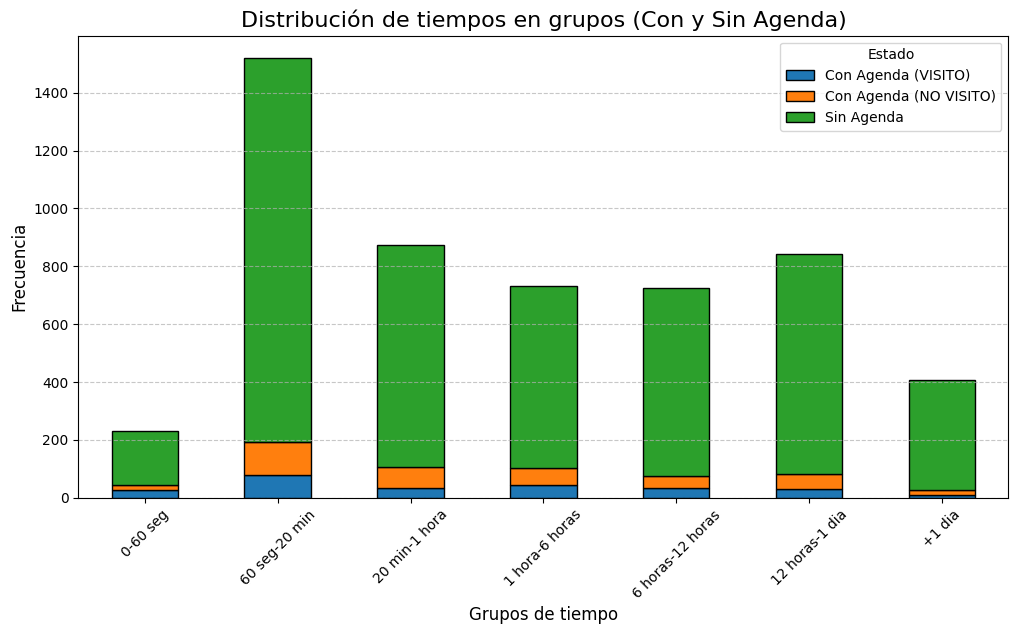

In [ ]:
# Crear los límites para los grupos de tiempo (en segundos)
bins = [0,60, 20*60, 60*60,21600,43200,86400, float('inf')]  # Límites en segundos
labels = ['0-60 seg', '60 seg-20 min', '20 min-1 hora','1 hora-6 horas','6 horas-12 horas', '12 horas-1 dia',"+1 dia"]

# Convertir 'tiempo_lead' a segundos
minimosAgenda['tiempo_lead_segundos'] = minimosAgenda['tiempo_lead'].dt.total_seconds()
minimosSinAgenda['tiempo_lead_segundos'] = minimosSinAgenda['tiempo_lead'].dt.total_seconds()

# Crear la columna de grupos en ambos conjuntos
minimosAgenda['grupo_tiempo_lead'] = pd.cut(minimosAgenda['tiempo_lead_segundos'], bins=bins, labels=labels)
minimosSinAgenda['grupo_tiempo_lead'] = pd.cut(minimosSinAgenda['tiempo_lead_segundos'], bins=bins, labels=labels)

concatTiempos = pd.concat([minimosAgenda['tiempo_lead_segundos'],minimosSinAgenda['tiempo_lead_segundos']],  
    ignore_index=True           
).dropna()         

# Separar "Con Agenda" en "visitado" y "no visitado"
conAgendaVisita = minimosAgenda[minimosAgenda['Estado Reunión'] == 'REALIZADO']
conAgendaNoVisita = minimosAgenda[minimosAgenda['Estado Reunión'] != 'REALIZADO']

# Contar las ocurrencias en cada grupo para ambos conjuntos
countAgendaVisita = conAgendaVisita['grupo_tiempo_lead'].value_counts(sort=False)
countAgendaNoVisita = conAgendaNoVisita['grupo_tiempo_lead'].value_counts(sort=False)
countNoAgenda = minimosSinAgenda['grupo_tiempo_lead'].value_counts(sort=False)
# Crear un DataFrame con los datos para el gráfico apilado
data = pd.DataFrame({
    'Con Agenda (VISITO)': countAgendaVisita,
    'Con Agenda (NO VISITO)': countAgendaNoVisita,
    'Sin Agenda': countNoAgenda
})
# Graficar el histograma apilado
data.plot(kind='bar', stacked=True, figsize=(12, 6), edgecolor='black')
plt.title('Distribución de tiempos en grupos (Con y Sin Agenda)', fontsize=16)
plt.xlabel('Grupos de tiempo', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Estado", fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



In [15]:
dataCompleto = data.copy()
# Calcular los totales por grupo
dataCompleto['Total'] = dataCompleto['Con Agenda (VISITO)'] + dataCompleto['Con Agenda (NO VISITO)'] + dataCompleto['Sin Agenda']

# Calcular los porcentajes
dataCompleto['% Con Agenda'] = ((dataCompleto['Con Agenda (VISITO)'] + dataCompleto['Con Agenda (NO VISITO)']) / dataCompleto['Total']) * 100
dataCompleto['% Sin Agenda'] = (dataCompleto['Sin Agenda'] / dataCompleto['Total']) * 100

dataCompleto["totalAgenda"] = dataCompleto['Con Agenda (VISITO)'] + dataCompleto['Con Agenda (NO VISITO)']
dataCompleto[" % visitaron" ] = (dataCompleto['Con Agenda (VISITO)'] /dataCompleto["Total"] )*100
dataCompleto[" % NO visitaron" ] = (dataCompleto['Con Agenda (NO VISITO)'] /dataCompleto["Total"] )*100
print(dataCompleto)


                   Con Agenda (VISITO)  Con Agenda (NO VISITO)  Sin Agenda  \
grupo_tiempo_lead                                                            
0-60 seg                            26                      19         184   
60 seg-20 min                       79                     113        1329   
20 min-1 hora                       35                      71         767   
1 hora-6 horas                      42                      59         630   
6 horas-12 horas                    33                      43         648   
12 horas-1 dia                      31                      51         761   
+1 dia                               8                      20         379   

                   Total  % Con Agenda  % Sin Agenda  totalAgenda  \
grupo_tiempo_lead                                                   
0-60 seg             229     19.650655     80.349345           45   
60 seg-20 min       1521     12.623274     87.376726          192   
20 min-1 hora        

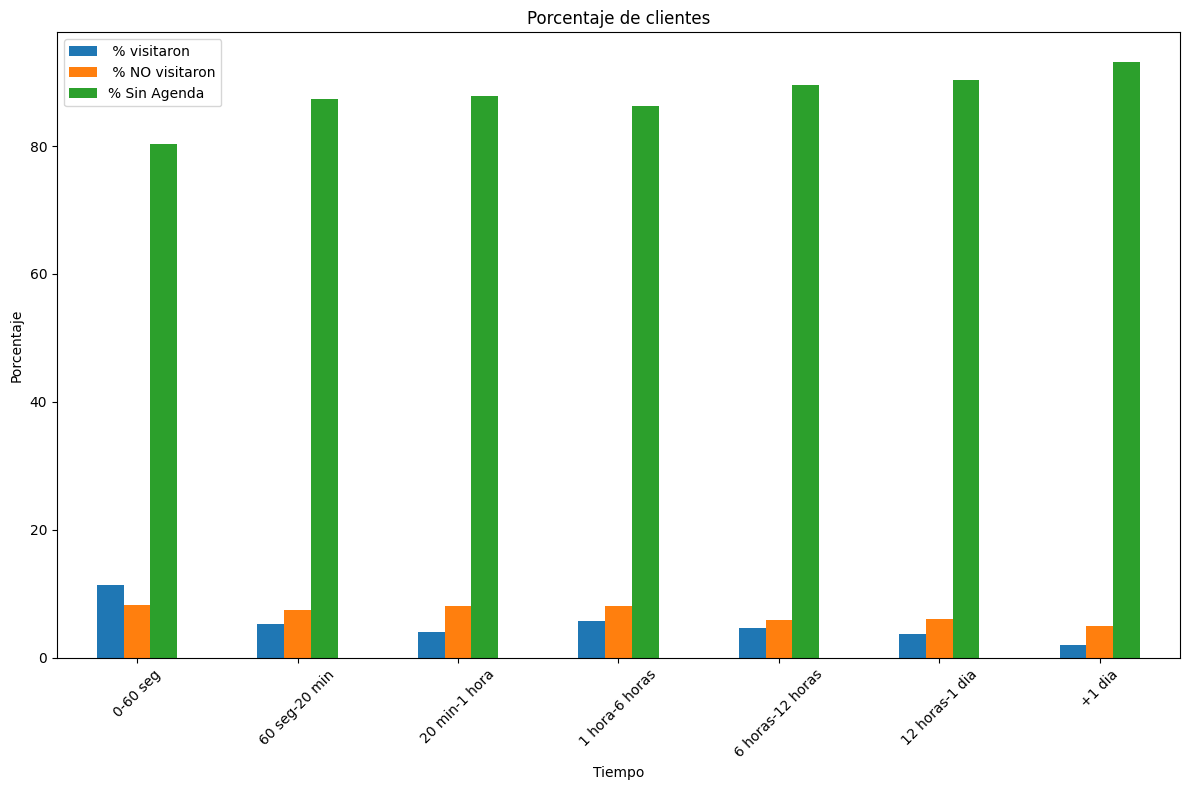

In [16]:
# Seleccionar las columnas de porcentajes
dataPorcentajes = dataCompleto[[' % visitaron', ' % NO visitaron', '% Sin Agenda']]

# Crear el gráfico de barras agrupadas
dataPorcentajes.plot(kind='bar', figsize=(12, 8))


plt.title('Porcentaje de clientes')
plt.xlabel('Tiempo')
plt.ylabel('Porcentaje')
plt.xticks(range(len(dataPorcentajes.index)), dataPorcentajes.index, rotation=45)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


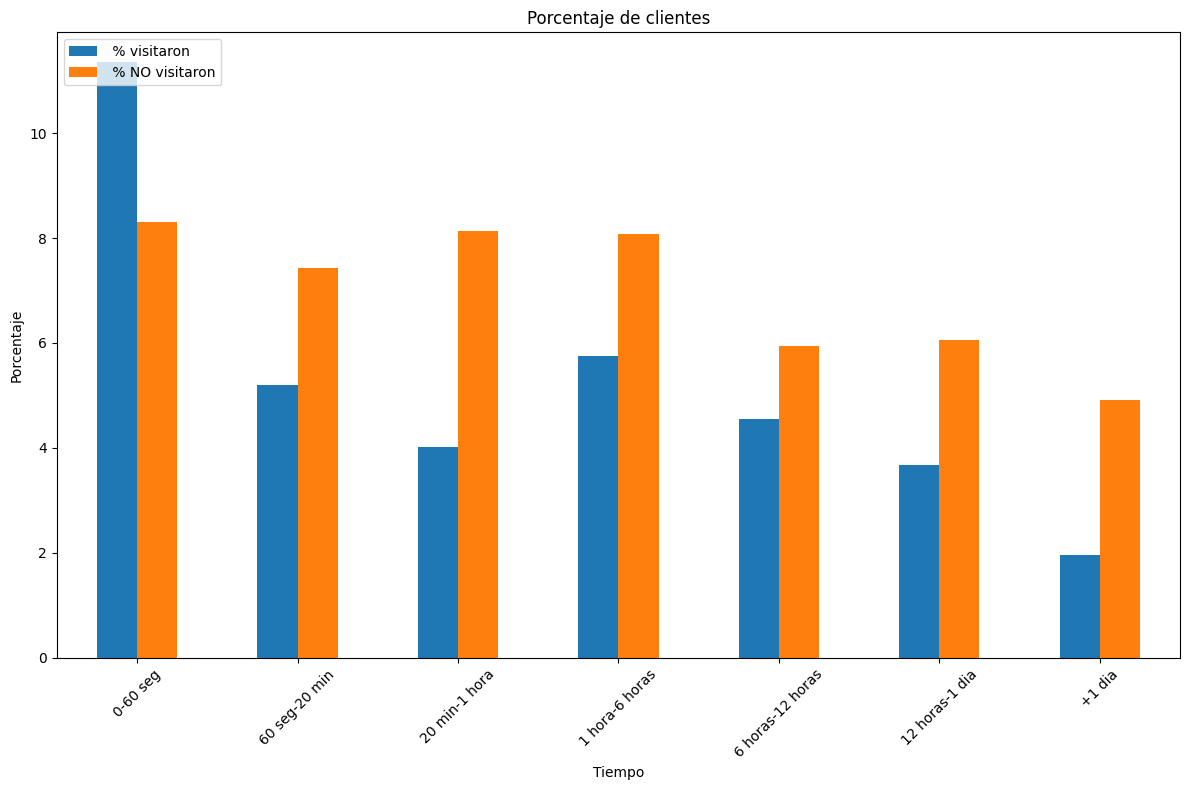

In [17]:
# Seleccionar las columnas de porcentajes
dataPorcentajes = dataCompleto[[' % visitaron', ' % NO visitaron']]

# Crear el gráfico de barras agrupadas
dataPorcentajes.plot(kind='bar', figsize=(12, 8))


plt.title('Porcentaje de clientes')
plt.xlabel('Tiempo')
plt.ylabel('Porcentaje')
plt.xticks(range(len(dataPorcentajes.index)), dataPorcentajes.index, rotation=45)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


<h1 style="color:green">Vemos el efecto fuera de horario de atención</h1>

Cruzar con etapa de la noche, separamos los sabados y domingos

In [18]:
#Categorizamos los dias

minimosAgenda["weekend"] = minimosAgenda["lead_created"].dt.day_name()
minimosSinAgenda["weekend"] = minimosSinAgenda["lead_created"].dt.day_name()

dataSemanaAgenda = minimosAgenda.copy()
dataSemanaSinAgenda = minimosSinAgenda.copy()

dataFinDeSemanaAgenda = minimosAgenda.copy()
dataFinDeSemanaSinAgenda = minimosSinAgenda.copy()

## filtro los dias de semana
dataSemanaAgenda = dataSemanaAgenda[~dataSemanaAgenda["weekend"].isin(['Saturday', 'Sunday'])]
dataSemanaSinAgenda = dataSemanaSinAgenda[~dataSemanaSinAgenda["weekend"].isin(['Saturday', 'Sunday'])]

## filtro los dias de semana
dataFinDeSemanaAgenda = dataFinDeSemanaAgenda[dataFinDeSemanaAgenda["weekend"].isin(['Saturday', 'Sunday'])]
dataFinDeSemanaSinAgenda = dataFinDeSemanaSinAgenda[dataFinDeSemanaSinAgenda["weekend"].isin(['Saturday', 'Sunday'])]



<h1 style="color:lightgreen"> Repito el grafico excluyendo fin de semana<h1>

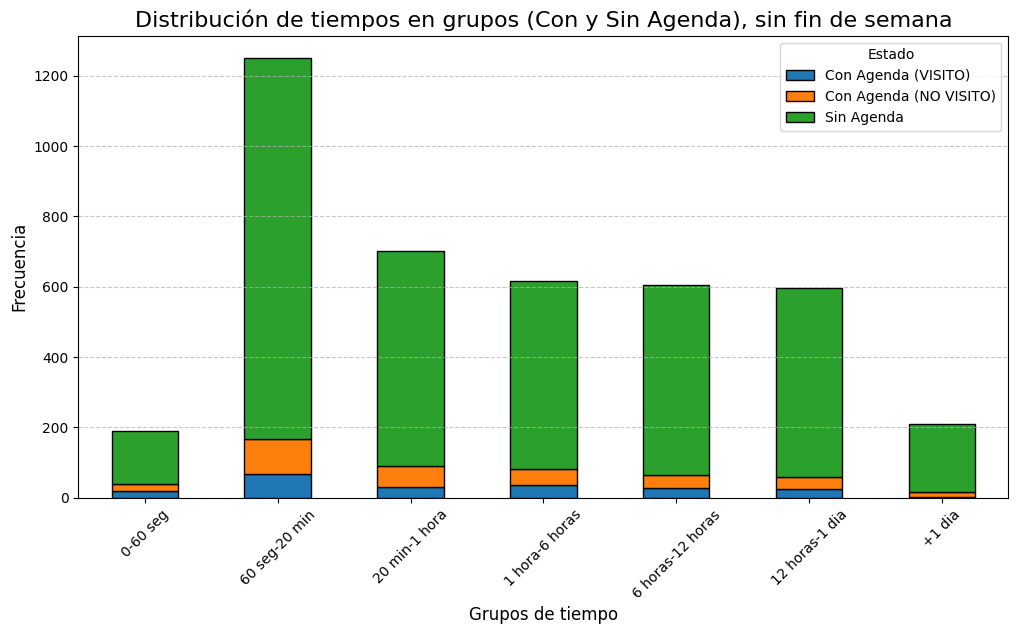

In [19]:
bins = [0, 60, 20*60, 60*60,21600,43200,86400, float('inf')]  # Límites en segundos
labels = ['0-60 seg', '60 seg-20 min', '20 min-1 hora','1 hora-6 horas','6 horas-12 horas', '12 horas-1 dia',"+1 dia"]

# Separar "Con Agenda" en "REALIZADO" y "NO REALIZADO"
conAgendaVisita = dataSemanaAgenda[dataSemanaAgenda['Estado Reunión'] == 'REALIZADO'].copy()
conAgendaNoVisita = dataSemanaAgenda[dataSemanaAgenda['Estado Reunión'] != 'REALIZADO'].copy()

# Contar las ocurrencias en cada grupo para ambos conjuntos
countAgendaVisita = conAgendaVisita['grupo_tiempo_lead'].value_counts(sort=False)
countAgendaNoVisita = conAgendaNoVisita['grupo_tiempo_lead'].value_counts(sort=False)
countNoAgenda = dataSemanaSinAgenda['grupo_tiempo_lead'].value_counts(sort=False)

# Crear un DataFrame con los datos para el gráfico apilado
data = pd.DataFrame({
    'Con Agenda (VISITO)': countAgendaVisita,
    'Con Agenda (NO VISITO)': countAgendaNoVisita,
    'Sin Agenda': countNoAgenda
})

# Graficar el histograma apilado
data.plot(kind='bar', stacked=True, figsize=(12, 6), edgecolor='black')
plt.title('Distribución de tiempos en grupos (Con y Sin Agenda), sin fin de semana', fontsize=16)
plt.xlabel('Grupos de tiempo', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Estado", fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [20]:
dataCompletoSinFinde = data
# Calcular los totales por grupo
dataCompletoSinFinde['Total'] = dataCompletoSinFinde['Con Agenda (VISITO)'] + dataCompletoSinFinde['Con Agenda (NO VISITO)'] + data['Sin Agenda']

# Calcular los porcentajes
dataCompletoSinFinde['% Con Agenda'] = ((dataCompletoSinFinde['Con Agenda (VISITO)'] + dataCompletoSinFinde['Con Agenda (NO VISITO)']) / dataCompletoSinFinde['Total']) * 100
dataCompletoSinFinde['% Sin Agenda'] = (dataCompletoSinFinde['Sin Agenda'] / dataCompletoSinFinde['Total']) * 100

dataCompletoSinFinde["totalAgenda"] = dataCompletoSinFinde['Con Agenda (VISITO)'] + dataCompletoSinFinde['Con Agenda (NO VISITO)']
dataCompletoSinFinde[" % visitaron" ] = (dataCompletoSinFinde['Con Agenda (VISITO)'] /dataCompletoSinFinde["Total"] )*100
dataCompletoSinFinde[" % NO visitaron" ] = (dataCompletoSinFinde['Con Agenda (NO VISITO)'] /dataCompletoSinFinde["Total"] )*100
print(dataCompletoSinFinde)

                   Con Agenda (VISITO)  Con Agenda (NO VISITO)  Sin Agenda  \
grupo_tiempo_lead                                                            
0-60 seg                            20                      19         151   
60 seg-20 min                       68                     100        1083   
20 min-1 hora                       29                      60         612   
1 hora-6 horas                      35                      47         534   
6 horas-12 horas                    28                      37         541   
12 horas-1 dia                      25                      34         536   
+1 dia                               3                      14         191   

                   Total  % Con Agenda  % Sin Agenda  totalAgenda  \
grupo_tiempo_lead                                                   
0-60 seg             190     20.526316     79.473684           39   
60 seg-20 min       1251     13.429257     86.570743          168   
20 min-1 hora        

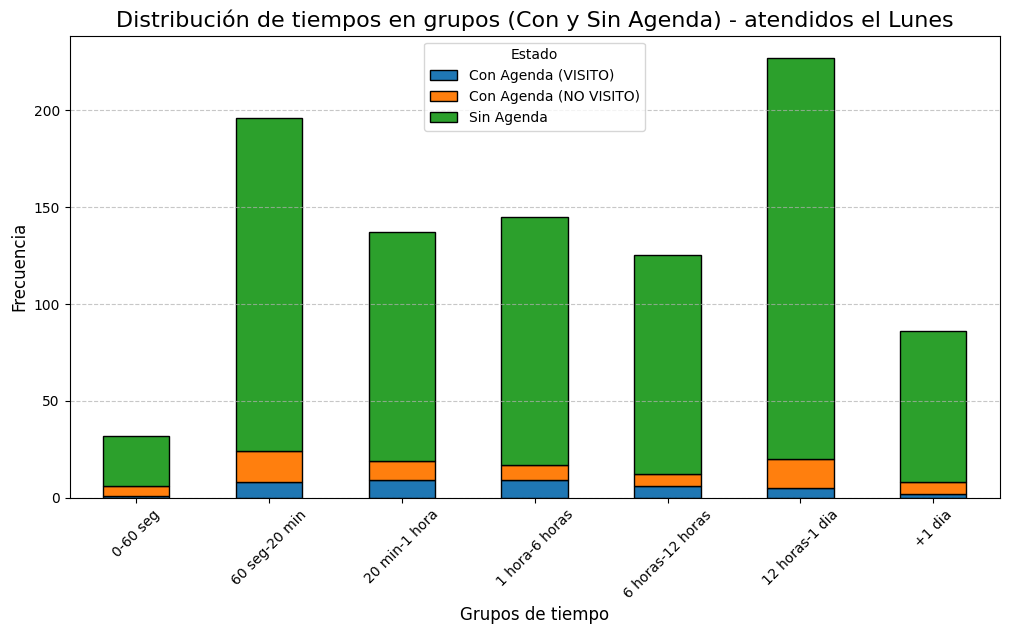

In [21]:
# Filtrar los datasets para quedarte solo con los datos del día lunes
minimosAgenda["weekendAtencion"] = minimosAgenda["fechaHora"].dt.day_name()
minimosSinAgenda["weekendAtencion"] = minimosSinAgenda["fechaHora"].dt.day_name()

dataAgendaMonday = minimosAgenda[minimosAgenda['weekendAtencion'] == 'Monday']
dataSinAgendaMonday = minimosSinAgenda[minimosSinAgenda['weekendAtencion'] == 'Monday']

# Separar "Con Agenda" en "REALIZADO" y "NO REALIZADO"
conAgendaVisita = dataAgendaMonday[dataAgendaMonday['Estado Reunión'] == 'REALIZADO'].copy()
conAgendaNoVisita = dataAgendaMonday[dataAgendaMonday['Estado Reunión'] != 'REALIZADO'].copy()

# Contar las ocurrencias en cada grupo para ambos conjuntos
countAgendaVisita = conAgendaVisita['grupo_tiempo_lead'].value_counts(sort=False)
countAgendaNoVisita = conAgendaNoVisita['grupo_tiempo_lead'].value_counts(sort=False)
countNoAgenda = dataSinAgendaMonday['grupo_tiempo_lead'].value_counts(sort=False)

# Crear un DataFrame con los datos para el gráfico apilado
data = pd.DataFrame({
    'Con Agenda (VISITO)': countAgendaVisita,
    'Con Agenda (NO VISITO)': countAgendaNoVisita,
    'Sin Agenda': countNoAgenda
})

# Graficar el histograma apilado
data.plot(kind='bar', stacked=True, figsize=(12, 6), edgecolor='black')
plt.title('Distribución de tiempos en grupos (Con y Sin Agenda) - atendidos el Lunes', fontsize=16)
plt.xlabel('Grupos de tiempo', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Estado", fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [22]:
dataCompletoLunes = data.copy()
# Calcular los totales por grupo
dataCompletoLunes['Total'] = dataCompletoLunes['Con Agenda (VISITO)'] + dataCompletoLunes['Con Agenda (NO VISITO)'] + data['Sin Agenda']

# Calcular los porcentajes
dataCompletoLunes['% Con Agenda'] = ((dataCompletoLunes['Con Agenda (VISITO)'] + dataCompletoLunes['Con Agenda (NO VISITO)']) / dataCompletoLunes['Total']) * 100
dataCompletoLunes['% Sin Agenda'] = (dataCompletoLunes['Sin Agenda'] / dataCompletoLunes['Total']) * 100

dataCompletoLunes["totalAgenda"] = dataCompletoLunes['Con Agenda (VISITO)'] + dataCompletoLunes['Con Agenda (NO VISITO)']
dataCompletoLunes[" % visitaron" ] = (dataCompletoLunes['Con Agenda (VISITO)'] /dataCompletoLunes["Total"] )*100
dataCompletoLunes[" % NO visitaron" ] = (dataCompletoLunes['Con Agenda (NO VISITO)'] /dataCompletoLunes["Total"] )*100
print(dataCompletoLunes)

                   Con Agenda (VISITO)  Con Agenda (NO VISITO)  Sin Agenda  \
grupo_tiempo_lead                                                            
0-60 seg                             1                       5          26   
60 seg-20 min                        8                      16         172   
20 min-1 hora                        9                      10         118   
1 hora-6 horas                       9                       8         128   
6 horas-12 horas                     6                       6         113   
12 horas-1 dia                       5                      15         207   
+1 dia                               2                       6          78   

                   Total  % Con Agenda  % Sin Agenda  totalAgenda  \
grupo_tiempo_lead                                                   
0-60 seg              32     18.750000     81.250000            6   
60 seg-20 min        196     12.244898     87.755102           24   
20 min-1 hora        

<h1 style="color:lightgreen" >Repito el grafico solo sabado y domingo</h1>

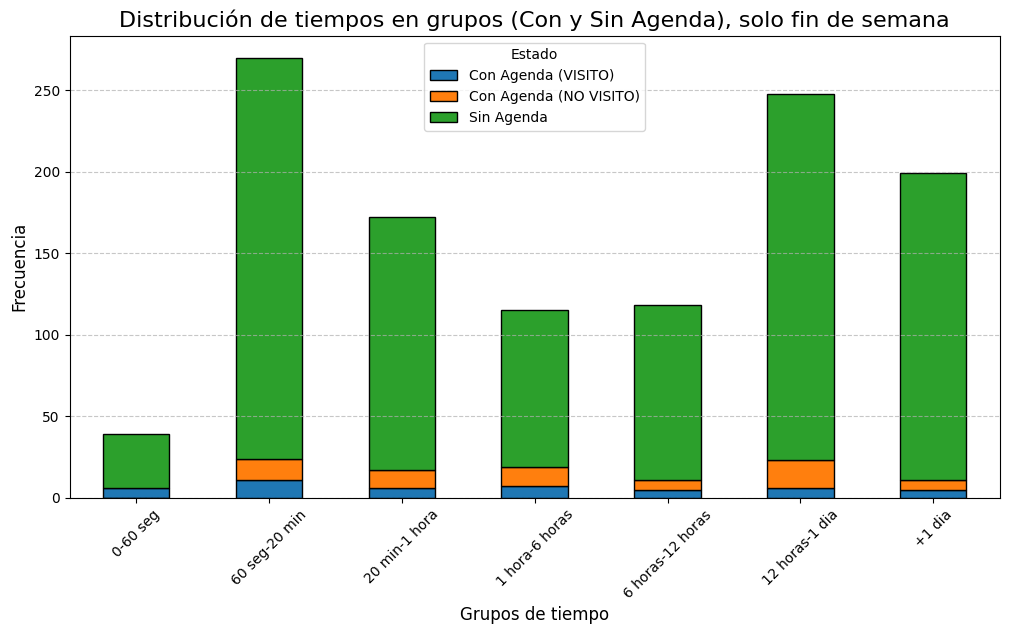

In [23]:
bins = [0, 60, 20*60, 60*60,21600,43200,86400, float('inf')]  # Límites en segundos
labels = ['0-60 seg', '60 seg-20 min', '20 min-1 hora','1 hora-6 horas','6 horas-12 horas', '12 horas-1 dia',"+1 dia"]

# Convertir 'tiempo_lead' a segundos
dataFinDeSemanaAgenda = dataFinDeSemanaAgenda.copy()
dataFinDeSemanaSinAgenda = dataFinDeSemanaSinAgenda.copy()

dataFinDeSemanaAgenda.loc[:, 'tiempo_lead_segundos'] = dataFinDeSemanaAgenda['tiempo_lead'].dt.total_seconds()
dataFinDeSemanaSinAgenda.loc[:, 'tiempo_lead_segundos'] = dataFinDeSemanaSinAgenda['tiempo_lead'].dt.total_seconds()

# Crear la columna de grupos en ambos conjuntos
dataFinDeSemanaAgenda.loc[:, 'grupo_tiempo_lead'] = pd.cut(dataFinDeSemanaAgenda['tiempo_lead_segundos'], bins=bins, labels=labels)
dataFinDeSemanaSinAgenda.loc[:, 'grupo_tiempo_lead'] = pd.cut(dataFinDeSemanaSinAgenda['tiempo_lead_segundos'], bins=bins, labels=labels)

# Separar "Con Agenda" en "REALIZADO" y "NO REALIZADO"
conAgendaVisita = dataFinDeSemanaAgenda[dataFinDeSemanaAgenda['Estado Reunión'] == 'REALIZADO'].copy()
conAgendaNoVisita = dataFinDeSemanaAgenda[dataFinDeSemanaAgenda['Estado Reunión'] != 'REALIZADO'].copy()

# Contar las ocurrencias en cada grupo para ambos conjuntos
countAgendaVisita = conAgendaVisita['grupo_tiempo_lead'].value_counts(sort=False)
countAgendaNoVisita = conAgendaNoVisita['grupo_tiempo_lead'].value_counts(sort=False)
countNoAgenda = dataFinDeSemanaSinAgenda['grupo_tiempo_lead'].value_counts(sort=False)


dataFinde = pd.DataFrame({
    'Con Agenda (VISITO)': countAgendaVisita,
    'Con Agenda (NO VISITO)': countAgendaNoVisita,
    'Sin Agenda': countNoAgenda
})

# Graficar el histograma apilado
dataFinde.plot(kind='bar', stacked=True, figsize=(12, 6), edgecolor='black')
plt.title('Distribución de tiempos en grupos (Con y Sin Agenda), solo fin de semana', fontsize=16)
plt.xlabel('Grupos de tiempo', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Estado", fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [24]:
dataCompleto = dataFinde
# Calcular los totales por grupo
dataCompleto['Total'] = dataCompleto['Con Agenda (VISITO)'] + dataCompleto['Con Agenda (NO VISITO)'] + dataCompleto['Sin Agenda']

# Calcular los porcentajes
dataCompleto['% Con Agenda'] = ((dataCompleto['Con Agenda (VISITO)'] + dataCompleto['Con Agenda (NO VISITO)']) / dataCompleto['Total']) * 100
dataCompleto['% Sin Agenda'] = (dataCompleto['Sin Agenda'] / dataCompleto['Total']) * 100

dataCompleto["totalAgenda"] = dataCompleto['Con Agenda (VISITO)'] + dataCompleto['Con Agenda (NO VISITO)']
dataCompleto[" % visitaron" ] = (dataCompleto['Con Agenda (VISITO)'] /dataCompleto["Total"] )*100
dataCompleto[" % NO visitaron" ] = (dataCompleto['Con Agenda (NO VISITO)'] /dataCompleto["Total"] )*100

print(dataCompleto)

                   Con Agenda (VISITO)  Con Agenda (NO VISITO)  Sin Agenda  \
grupo_tiempo_lead                                                            
0-60 seg                             6                       0          33   
60 seg-20 min                       11                      13         246   
20 min-1 hora                        6                      11         155   
1 hora-6 horas                       7                      12          96   
6 horas-12 horas                     5                       6         107   
12 horas-1 dia                       6                      17         225   
+1 dia                               5                       6         188   

                   Total  % Con Agenda  % Sin Agenda  totalAgenda  \
grupo_tiempo_lead                                                   
0-60 seg              39     15.384615     84.615385            6   
60 seg-20 min        270      8.888889     91.111111           24   
20 min-1 hora        

C:\Users\GiovanniMiceli\AppData\Local\Temp\ipykernel_7260\3212001352.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = dataFinDeSemanaAgenda.groupby(['grupo_tiempo', 'Estado Reunión']).size().unstack()
C:\Users\GiovanniMiceli\AppData\Local\Temp\ipykernel_7260\3212001352.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts2 = dataFinDeSemanaSinAgenda.groupby(['grupo_tiempo']).size()
C:\Users\GiovanniMiceli\AppData\Local\Temp\ipykernel_7260\3212001352.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=Fals

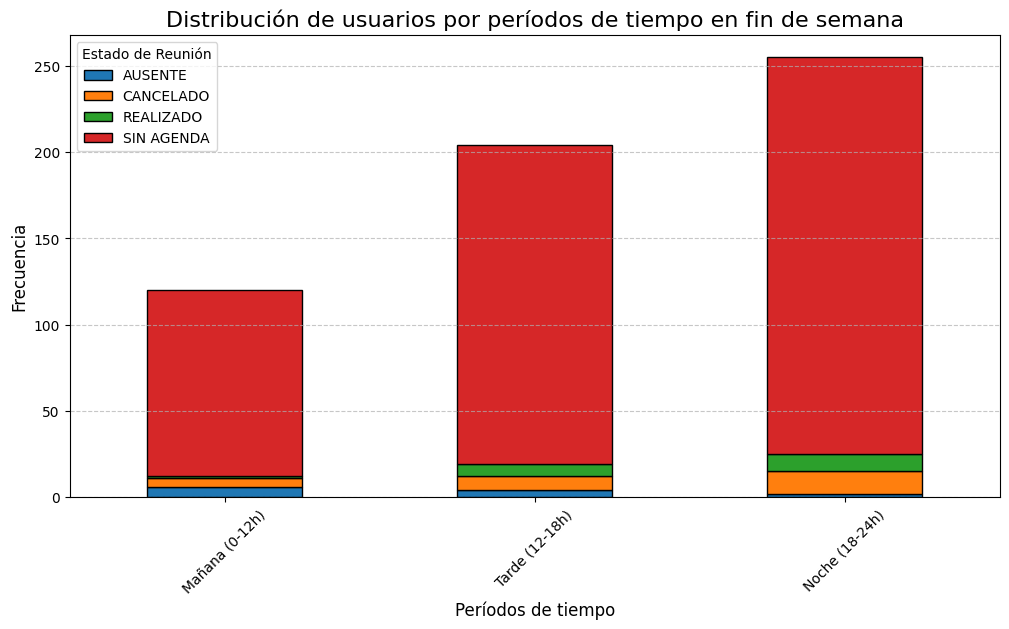

In [25]:
time_bins = [0, 12, 18, 24]  # Horas del día
time_labels = ['Mañana (0-12h)', 'Tarde (12-18h)', 'Noche (18-24h)']

dataFinDeSemanaAgenda['hour'] = dataFinDeSemanaAgenda['lead_created'].dt.hour

dataFinDeSemanaSinAgenda['hour'] = dataFinDeSemanaSinAgenda['lead_created'].dt.hour

# Crear la columna de grupos de tiempo
dataFinDeSemanaAgenda['grupo_tiempo'] = pd.cut(dataFinDeSemanaAgenda['hour'], bins=time_bins, labels=time_labels, right=False)

dataFinDeSemanaSinAgenda['grupo_tiempo'] = pd.cut(dataFinDeSemanaSinAgenda['hour'], bins=time_bins, labels=time_labels, right=False)
dataFinDeSemanaSinAgenda['Estado Reunión'] = 'SIN AGENDA'

# Contar las ocurrencias en cada grupo de tiempo y estado de reunión
counts = dataFinDeSemanaAgenda.groupby(['grupo_tiempo', 'Estado Reunión']).size().unstack()
counts2 = dataFinDeSemanaSinAgenda.groupby(['grupo_tiempo']).size()

df_combined = pd.concat([dataFinDeSemanaAgenda, dataFinDeSemanaSinAgenda], ignore_index=True)
df_combined = df_combined[df_combined['lead_created'].dt.day_name() == 'Sunday']

counts_combined = df_combined.groupby(['grupo_tiempo', 'Estado Reunión']).size().unstack()

# Graficar el histograma de barras
counts_combined.plot(kind='bar', stacked=True, figsize=(12, 6), edgecolor='black')
plt.title('Distribución de usuarios por períodos de tiempo en fin de semana', fontsize=16)
plt.xlabel('Períodos de tiempo', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Estado de Reunión", fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

329
5328
Perderiamos un 6.17% de las entradas


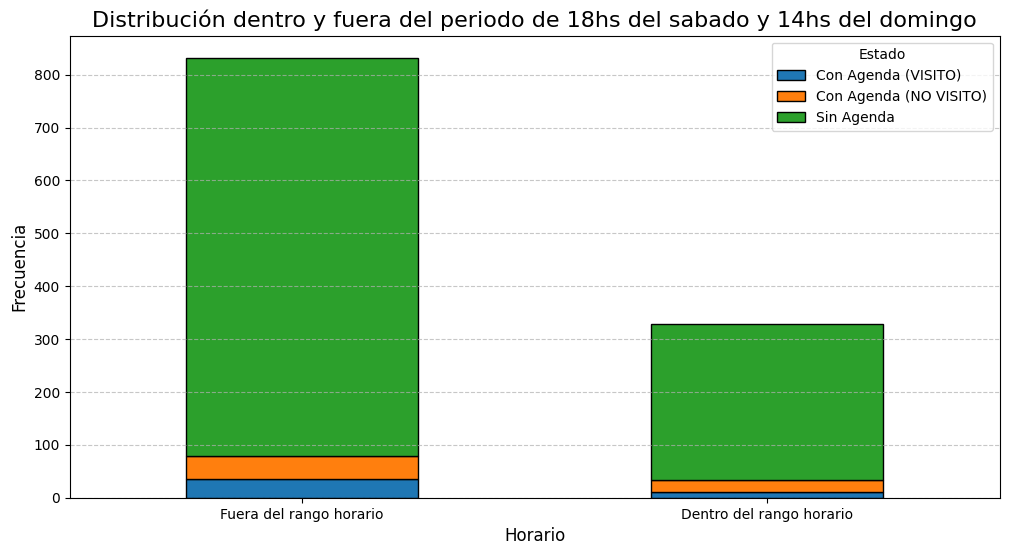

                          Con Agenda (VISITO)  Con Agenda (NO VISITO)  \
hipotesis                                                               
Fuera del rango horario                    35                      43   
Dentro del rango horario                   11                      22   

                          Sin Agenda  Total  % Con Agenda  % Sin Agenda  \
hipotesis                                                                 
Fuera del rango horario          754    832      9.375000     90.625000   
Dentro del rango horario         296    329     10.030395     89.969605   

                          totalAgenda   % visitaron   % NO visitaron  
hipotesis                                                             
Fuera del rango horario            78      4.206731         5.168269  
Dentro del rango horario           33      3.343465         6.686930  


In [26]:
f.hipotesis(dataFinDeSemanaAgenda,dataFinDeSemanaSinAgenda,minimosAgenda,minimosSinAgenda)

## <h2 style="color:white">Repito lo previo para el resto de los dias.</h2>


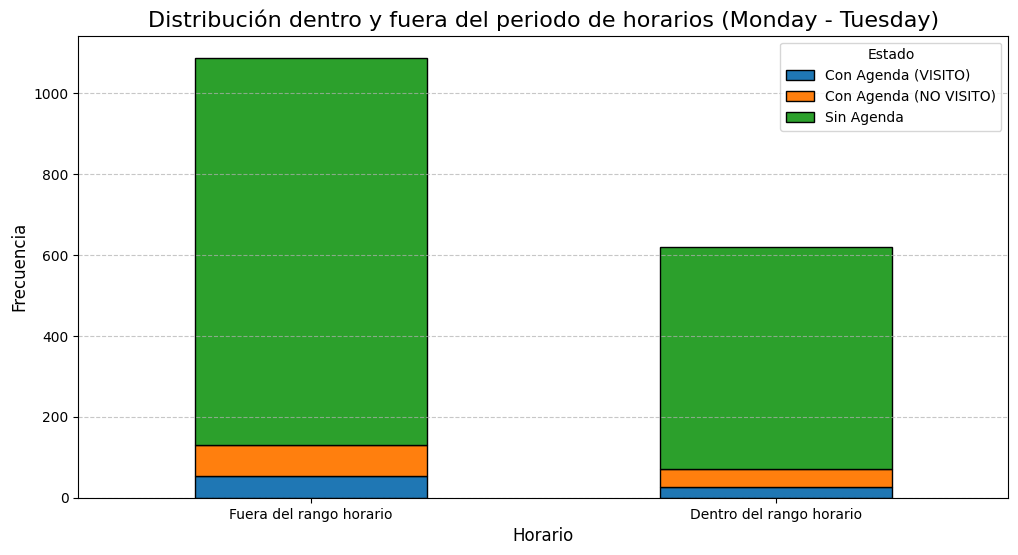


Análisis para Monday - Tuesday
                          Con Agenda (VISITO)  Con Agenda (NO VISITO)  \
hipotesis                                                               
Fuera del rango horario                    53                      77   
Dentro del rango horario                   27                      43   

                          Sin Agenda  Total  % Con Agenda  % Sin Agenda  \
hipotesis                                                                 
Fuera del rango horario          958   1088     11.948529     88.051471   
Dentro del rango horario         550    620     11.290323     88.709677   

                          totalAgenda   % visitaron   % NO visitaron  
hipotesis                                                             
Fuera del rango horario           130      4.871324         7.077206  
Dentro del rango horario           70      4.354839         6.935484  


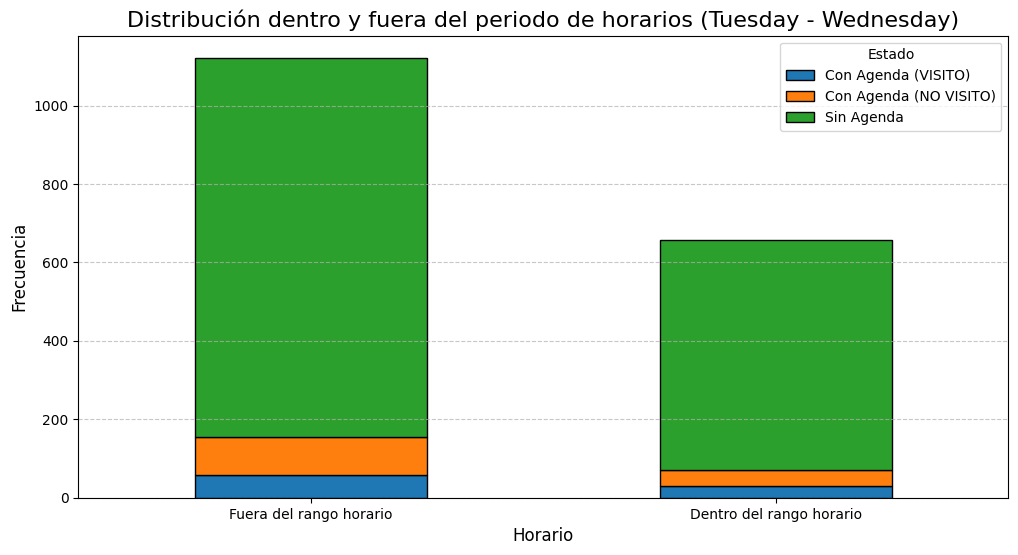


Análisis para Tuesday - Wednesday
                          Con Agenda (VISITO)  Con Agenda (NO VISITO)  \
hipotesis                                                               
Fuera del rango horario                    58                      97   
Dentro del rango horario                   30                      41   

                          Sin Agenda  Total  % Con Agenda  % Sin Agenda  \
hipotesis                                                                 
Fuera del rango horario          967   1122     13.814617     86.185383   
Dentro del rango horario         585    656     10.823171     89.176829   

                          totalAgenda   % visitaron   % NO visitaron  
hipotesis                                                             
Fuera del rango horario           155      5.169340         8.645276  
Dentro del rango horario           71      4.573171         6.250000  


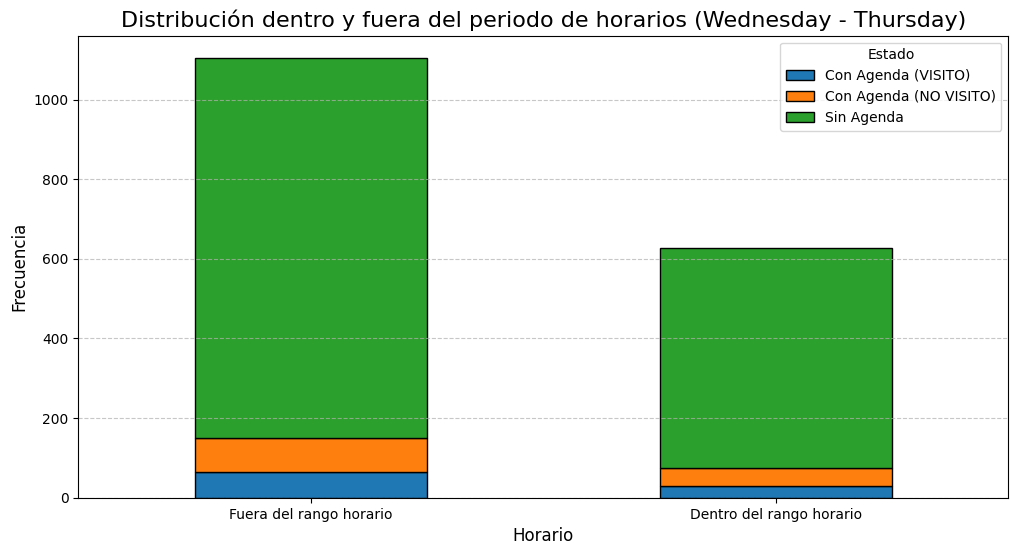


Análisis para Wednesday - Thursday
                          Con Agenda (VISITO)  Con Agenda (NO VISITO)  \
hipotesis                                                               
Fuera del rango horario                    64                      87   
Dentro del rango horario                   30                      45   

                          Sin Agenda  Total  % Con Agenda  % Sin Agenda  \
hipotesis                                                                 
Fuera del rango horario          954   1105     13.665158     86.334842   
Dentro del rango horario         551    626     11.980831     88.019169   

                          totalAgenda   % visitaron   % NO visitaron  
hipotesis                                                             
Fuera del rango horario           151      5.791855         7.873303  
Dentro del rango horario           75      4.792332         7.188498  


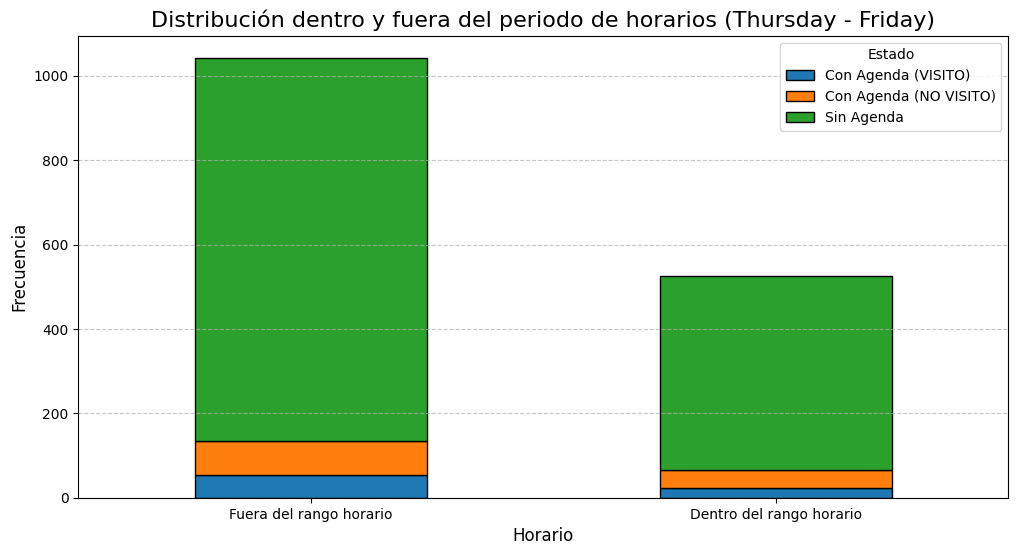


Análisis para Thursday - Friday
                          Con Agenda (VISITO)  Con Agenda (NO VISITO)  \
hipotesis                                                               
Fuera del rango horario                    55                      79   
Dentro del rango horario                   24                      42   

                          Sin Agenda  Total  % Con Agenda  % Sin Agenda  \
hipotesis                                                                 
Fuera del rango horario          909   1043     12.847555     87.152445   
Dentro del rango horario         459    525     12.571429     87.428571   

                          totalAgenda   % visitaron   % NO visitaron  
hipotesis                                                             
Fuera del rango horario           134      5.273250         7.574305  
Dentro del rango horario           66      4.571429         8.000000  


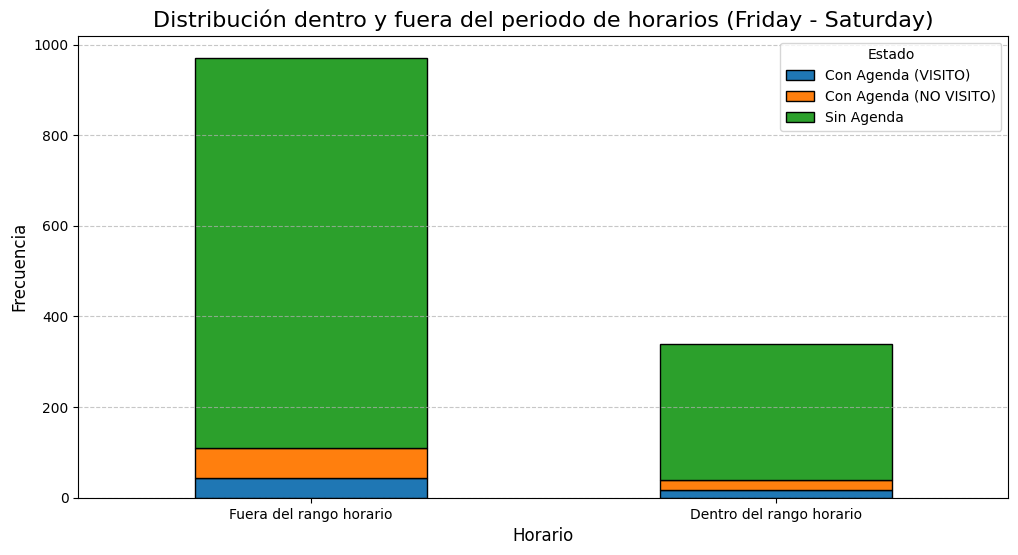


Análisis para Friday - Saturday
                          Con Agenda (VISITO)  Con Agenda (NO VISITO)  \
hipotesis                                                               
Fuera del rango horario                    44                      65   
Dentro del rango horario                   18                      21   

                          Sin Agenda  Total  % Con Agenda  % Sin Agenda  \
hipotesis                                                                 
Fuera del rango horario          862    971     11.225541     88.774459   
Dentro del rango horario         300    339     11.504425     88.495575   

                          totalAgenda   % visitaron   % NO visitaron  
hipotesis                                                             
Fuera del rango horario           109      4.531411          6.69413  
Dentro del rango horario           39      5.309735          6.19469  


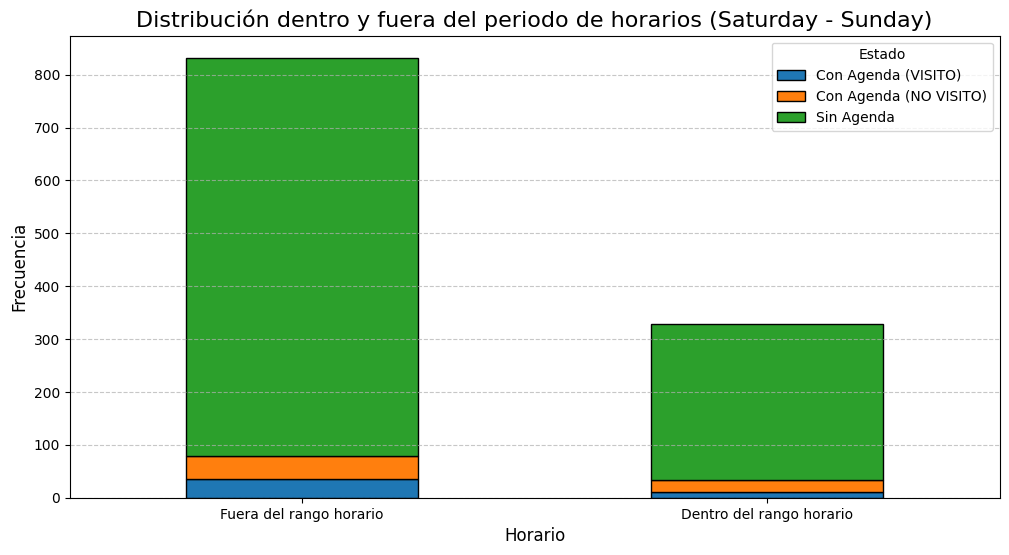


Análisis para Saturday - Sunday
                          Con Agenda (VISITO)  Con Agenda (NO VISITO)  \
hipotesis                                                               
Fuera del rango horario                    35                      43   
Dentro del rango horario                   11                      22   

                          Sin Agenda  Total  % Con Agenda  % Sin Agenda  \
hipotesis                                                                 
Fuera del rango horario          754    832      9.375000     90.625000   
Dentro del rango horario         296    329     10.030395     89.969605   

                          totalAgenda   % visitaron   % NO visitaron  
hipotesis                                                             
Fuera del rango horario            78      4.206731         5.168269  
Dentro del rango horario           33      3.343465         6.686930  


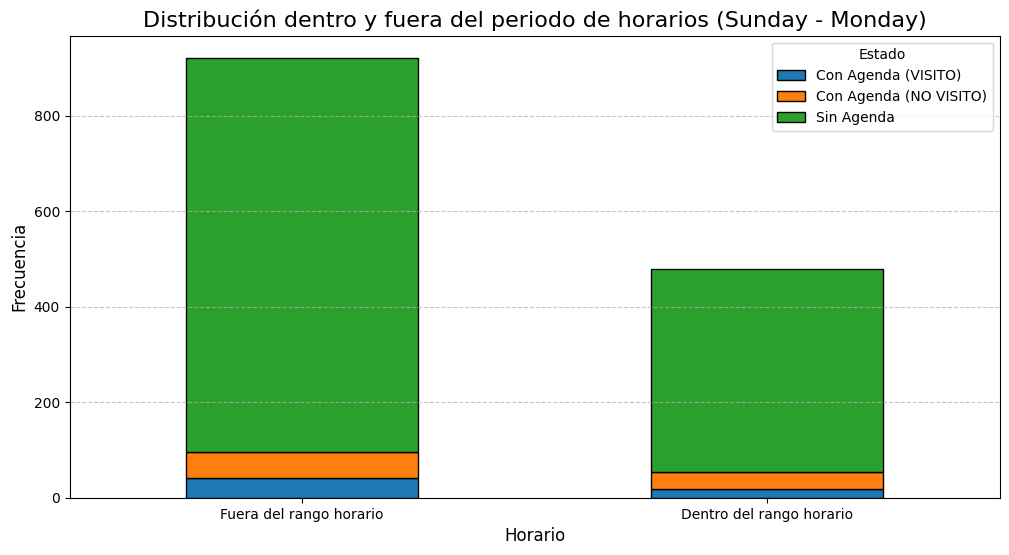


Análisis para Sunday - Monday
                          Con Agenda (VISITO)  Con Agenda (NO VISITO)  \
hipotesis                                                               
Fuera del rango horario                    41                      54   
Dentro del rango horario                   18                      36   

                          Sin Agenda  Total  % Con Agenda  % Sin Agenda  \
hipotesis                                                                 
Fuera del rango horario          826    921     10.314875     89.685125   
Dentro del rango horario         425    479     11.273486     88.726514   

                          totalAgenda   % visitaron   % NO visitaron  
hipotesis                                                             
Fuera del rango horario            95      4.451683         5.863192  
Dentro del rango horario           54      3.757829         7.515658  


In [27]:
f.analizar_horarios_por_pares(minimosAgenda,minimosSinAgenda)

## <h2 style="color:green">Veo cuantos ingresos hay dependiendo de si es horario laboral o no.</h2>

- primero lo hago con los dias de la semana

- Horario laboral del call center, 9 a 21

¿en que ocasiones se atiende fuera de horario? (por ejemplo, 9 pm) ¿ que se tiene que cumplir para que se atienda un sabado?

# <h2 style="color:red">Ver cuales son los minimos y maximos para estudiar la desviacion estandar de los horarios</h2>


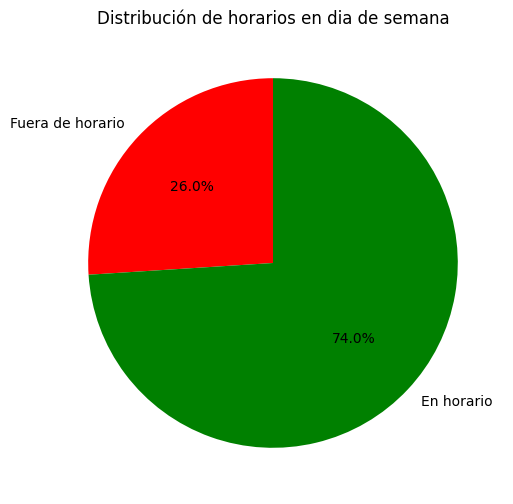

In [28]:
dataSemanaAgenda["fuera_de_horario"] = (dataSemanaAgenda["lead_created"].dt.hour < 9) | ( dataSemanaAgenda["lead_created"].dt.hour >= 21)

labels = ["Fuera de horario","En horario"]
counts = dataSemanaAgenda["fuera_de_horario"].value_counts()
sizes = [counts[True],counts[False]]

# Crear el gráfico de pastel
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['red', 'green'])
plt.title('Distribución de horarios en dia de semana')
plt.show()

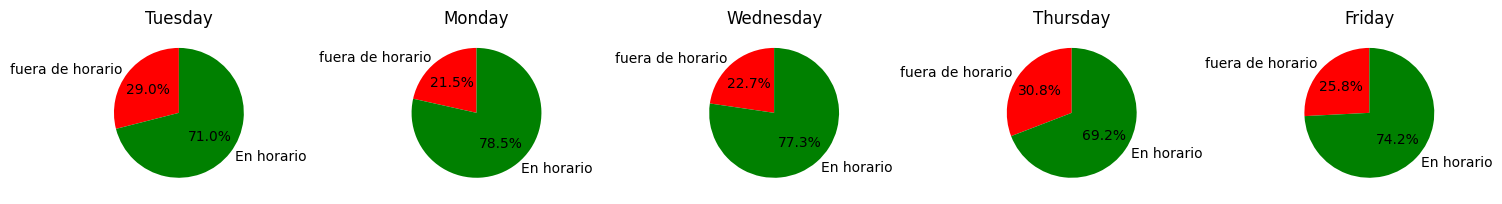

In [29]:
counts = dataSemanaAgenda.groupby('weekend')['fuera_de_horario'].value_counts().unstack(fill_value=0)

# Calcular porcentajes
percentages = counts.div(counts.sum(axis=1), axis=0) * 100


diasUnicos = dataSemanaAgenda['weekend'].unique()

# Crear la figura con subgráficos
fig, axes = plt.subplots(1, len(diasUnicos), figsize=(15, 5))

# Iterar sobre cada día y generar su pie chart
for ax, dia in zip(axes, diasUnicos):
    counts = dataSemanaAgenda[dataSemanaAgenda['weekend'] == dia]['fuera_de_horario'].value_counts()
    sizes = [counts.get(True, 0), counts.get(False, 0)]
    labels = ['fuera de horario', 'En horario']

    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['red', 'green'])
    ax.set_title(dia)

# Ajustar el layout
plt.tight_layout()
plt.show()

- Veo cantidad de gente por dia.

- Veo probabilidad de agenda dependiendo si estan fuera o dentro del horario laboral.

Estado Reunión    FALLIDA  INCORRECTO  REALIZADO
fuera_de_horario                                
False                 229           3        152
True                   79           0         56


ValueError: 'label' must be of length 'x'

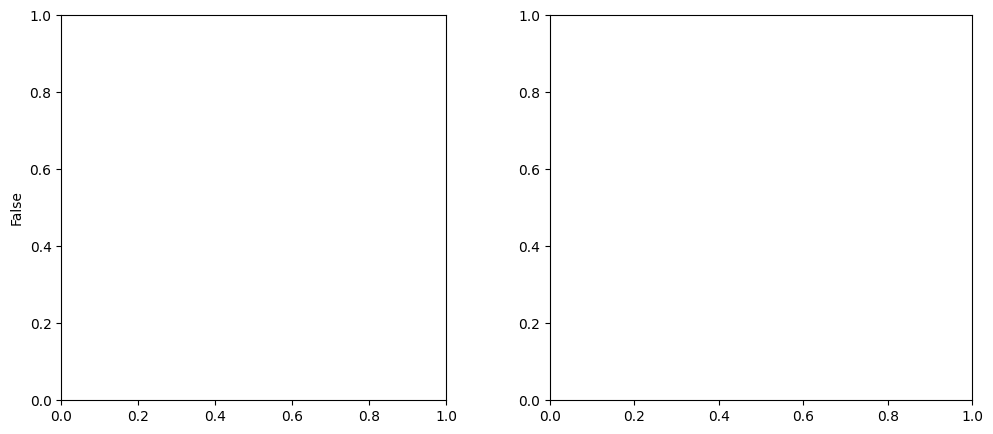

In [30]:
dataSemanaAgenda["Estado Reunión"] = dataSemanaAgenda["Estado Reunión"].replace(['ACTIVO', 'AUSENTE', 'CANCELADO'], 'FALLIDA')
counts = dataSemanaAgenda.groupby('fuera_de_horario')['Estado Reunión'].value_counts().unstack(fill_value=0)
percentages = counts.div(counts.sum(axis=1), axis=0) * 100
print(counts)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
labels=["NO VISITÓ","VISITÓ"]
for ax, (fuera_de_horario, row) in zip(axes, percentages.iterrows()):
    row.plot(kind='pie', autopct='%1.1f%%', startangle=90, ax=ax, colors=['red', 'green'],labels=labels)
    ax.set_title(f'{"Fuera de Horario" if fuera_de_horario else "Dentro de Horario"}')
    ax.set_ylabel('')  # Ocultar la etiqueta del eje Y

plt.tight_layout()
plt.show()

<h2 style="color:green">Ahora veo los fin de semana</h2>

- falta saber los horarios de atencion los fin de semana

In [ ]:
dataFinDeSemanaAgenda["fuera_de_horario"] = (dataFinDeSemanaAgenda["lead_created"].dt.hour < 9) | ( dataFinDeSemanaAgenda["lead_created"].dt.hour >= 21)

labels = ["Fuera de horario","En horario"]
counts = dataFinDeSemanaAgenda["fuera_de_horario"].value_counts()
sizes = [counts[True],counts[False]]

# Crear el gráfico de pastel
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['red', 'green'])
plt.title('Distribución de horarios en dia de semana')
plt.show()

In [ ]:
counts = dataFinDeSemanaAgenda.groupby('weekend')['fuera_de_horario'].value_counts().unstack(fill_value=0)

# Calcular porcentajes
percentages = counts.div(counts.sum(axis=1), axis=0) * 100


diasUnicos = dataFinDeSemanaAgenda['weekend'].unique()

# Crear la figura con subgráficos
fig, axes = plt.subplots(1, len(diasUnicos), figsize=(15, 5))

# Iterar sobre cada día y generar su pie chart
for ax, dia in zip(axes, diasUnicos):
    counts = dataFinDeSemanaAgenda[dataFinDeSemanaAgenda['weekend'] == dia]['fuera_de_horario'].value_counts()
    sizes = [counts.get(True, 0), counts.get(False, 0)]
    labels = ['fuera de horario', 'En horario']

    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['red', 'green'])
    ax.set_title(dia)

# Ajustar el layout
plt.tight_layout()
plt.show()

In [ ]:
print(dataFinDeSemanaAgenda["weekend"].value_counts())

In [ ]:
dataFinDeSemanaAgenda["Estado Reunión"] = dataFinDeSemanaAgenda["Estado Reunión"].replace(['ACTIVO', 'AUSENTE', 'CANCELADO'], 'FALLIDA')
counts = dataFinDeSemanaAgenda.groupby('fuera_de_horario')['Estado Reunión'].value_counts().unstack(fill_value=0)
percentages = counts.div(counts.sum(axis=1), axis=0) * 100
print(counts)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
labels=["NO VISITÓ","VISITÓ"]

for ax, (fuera_de_horario, row) in zip(axes, percentages.iterrows()):
    row.plot(kind='pie', autopct='%1.1f%%', startangle=90, ax=ax, colors=['red', 'green'],labels=labels)
    ax.set_title(f'{"Fuera de Horario laboral" if fuera_de_horario else "Dentro de Horario laboral"}')
    ax.set_ylabel('')  # Ocultar la etiqueta del eje Y

plt.tight_layout()
plt.show()